# Homework 4 
## Part 1: The $L^2$ Projection

### This is the solution of:
* Klas Henriksson klhe0017@student.umu.se
* Joel Nilsson joni0295@student.umu.se
* Daniel Dahlgren Lindström dali0125@student.umu.se


The same general rules as for Homework 1 applies.

$\newcommand{\dx}{\,\mathrm{d}x}$ 
$\newcommand{\dy}{\,\mathrm{d}y}$
$\newcommand{\dS}{\,\mathrm{d}S}$

In [5]:
# Make plotted figures interactive
%matplotlib notebook

In [8]:
from IPython.core.display import HTML
def css_styling():
    styles = open("custom-style.css", "r").read()
    return HTML(styles)

# Comment out next line and execute this cell to restore the default notebook style. 
css_styling()

Import relevant python modules and our own tiny helper modules.

In [7]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg.dsolve import spsolve
import matplotlib.pyplot as plt
import plottools as pt

Next, we define a surface plotting function for functions defined on triangle meshes.
The triangulation $\mathcal{K}_h$ is given by $n_t$ triangles $\{K\}_{i=0}^{n_t}$ 
and $n_p$ nodes $\{N_i\}_{i=0}^{n_p-1}$. As usual we assume that $\mathcal{K}_h$ is represented by its point matrix $P$ storing in column $j$ the $x$ and $y$ coordinate node $N_j$ of the triangulation, and the connectivity matrix $T$, which in
column $j$ stores the indices of those nodes which comprise triangle $K_j$.

The arguments ```X``` and ```Y``` correspond to the
$0$-th and $1$st row of the point matrix $P$ and ```Z``` is just the array containing
the function values at the nodes. The ```triangles``` argument takes the connectivity matrix $T$. 

In [2]:
def plot2D(X, Y, Z, triangles, title=''):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(X, Y, Z, triangles=triangles.copy(), cmap=cm.viridis, linewidth=0.0)
    ax.set_title(title)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')
    plt.show()

## Problem 1 (Point and Connectivity Matrices)

Determine the point and connectivity matrix for following triangulation.

<center>
<img src='mesh.png' width="800">
</center>

## Answer
$$
P = 
\begin{bmatrix}
0.0 & 0.0 \\
0.5 & 0.0 \\
1.0 & 0.0 \\
0.0 & 0.5 \\
0.5 & 0.5 \\
1.0 & 0.5 \\
0.0 & 1.0 \\
0.5 & 1.0 \\
1.0 & 1.0
\end{bmatrix}

T =
\begin{bmatrix}
3 & 1 & 4 \\
0 & 1 & 3 \\
1 & 5 & 4 \\
1 & 2 & 5 \\
3 & 4 & 7 \\
3 & 7 & 6 \\
7 & 4 & 5 \\
5 & 8 & 7 \\
\end{bmatrix}
$$

## Problem 2 (Exploring the meshtools module)

Download $\texttt{meshtools}$ module from the lab_04 folder. 
Import it as usual via

In [5]:
import meshtools as mt

and play around with the implemented functions. In particular, generate and plot 

**a**) a unitsquare mesh with meshsize $h = 1/N$ for $N=1,2,5$.

**b**) 3 rectangle meshes for $[a,b]\times[c,d] = [0,1]\times[2,4]$ for 
3 meshsizes of your choice.

Hint: read the code meshtools.py 

## Answer a&b)
See code below.

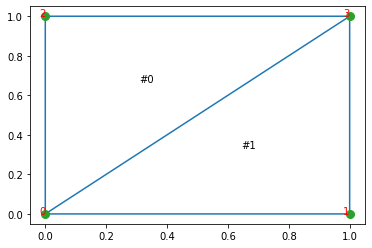

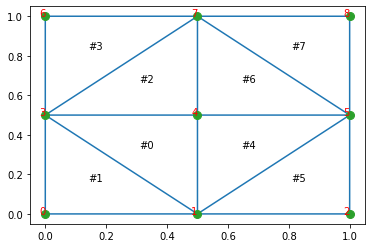

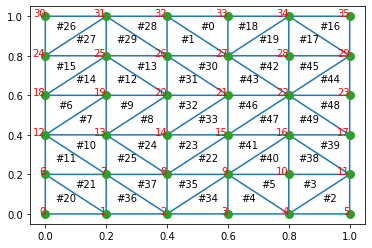

In [4]:
Ns = [1,2,5]

for N in Ns:
    (P, T) = mt.rectangle_mesh((0,0), (1,1), N, N)
    pt.plot_mesh_2d(P, T)
    

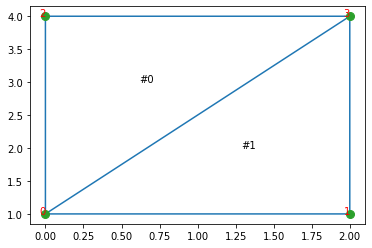

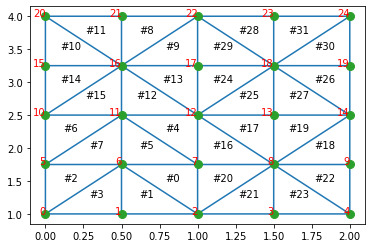

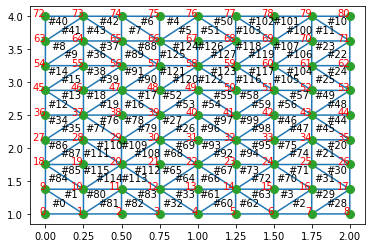

In [5]:
Ns = [1,4,8]
for N in Ns:
    (P,T) = mt.rectangle_mesh((0,1), (2,4), N, N)
    pt.plot_mesh_2d(P,T)

## Problem 3 ($L^2$ projection)

**a**) Let $f \in L^2(\Omega)$ and prove that the $L^2$ projection $P_h f \in V_h$ is uniquely defined.

Hint: prove by contradition. Assume there are two $L^2$ projections, ...

## Answer a)
A L2 projection is the function $P_h f$ obeying
$$ \int_\Omega (f - P_hf)v dxdy = 0 \quad \forall v \in V_h $$

Assume there are two projections $P_hf_1$, $P_hf_2$ onto the domain $V_h$. We then have that 
$$\int_\Omega (f - P_hf_1)v dxdy = 0 = \int_\Omega (f-P_hf_2)v dxdy. \quad \forall v \in V_h$$
Which we can rewrite as
$$\int_\Omega \left((f-P_hf_1) - (f-P_hf_2)\right)v dxdy = 0 = \int_\Omega (P_hf_2 - P_hf_1)v dxdy$$
Formulated as inner products we get
$$
\left<(P_hf_2 - P_hf_1), v\right> = 0. \quad \forall v \in V_h
$$
Since this holds for all v, it must also hold for $v = P_hf_2 - P_hf_1$. Inserting this choice of $v$ into the above equation gives 
$$
||P_hf_2 - P_hf_1||^2 = 0 \Leftrightarrow P_hf_1 = P_hf_2,
$$
which proves the uniqueness of the L2 projection onto $V_h$. 


**b**) For a given domain, let $\mathcal{K}_h = \{K_i\}_{i=0}^{n_t-1}$ be a triangulation represent through its point matrix $P$ and its connectivity matrix $T$. As usual, let $V_h$
be the space of continuous, piecewise linear functions defined on $\mathcal{K}_h$

Write a Python function ```assemble_mass_matrix(P, T)``` which assembles the mass
matrix associated with the $L^2$ projection onto $V_h$. Start from the following code outline.

### Code Outline

In [2]:
def assemble_mass_matrix(P, T):
    # Define constant part M_K here
    M_ref = (1/12)*np.array(
        ((2, 1, 1),
        (1,2,1),
        (1,1,2))
    )
    
    # Deduce number of unkowns from dimensions/shape of P
    n_p = P.shape[0]
    # Deduce number of elements from dimensions of T
    n_t = T.shape[0]
    
    # Create sparse matrix M
    M = sp.dok_matrix((n_p, n_p))
    
    for K in range(n_t):
        # Get local to global map from T
        l2g = T[K,:]
        # Get triangle nodes from P
        tri = P[l2g, :]
        # Unpack nodes into N1,N2,N3
        N0,N1,N2 = tri 
        # Compute area of K. 
        # Convince yourself that the following line computes the area |K|
        area=abs(0.5*np.cross(N1-N0,N2-N0))
        # Use area and M_ref to compute M_K
        M_K = area * M_ref
        # Instead of 2 loops we can slice out the blocks which
        # corresponds to the entries in l2g by using the funny
        # function ix_ in numpy
        M[np.ix_(l2g, l2g)] += M_K
    
    return M

**c**) Next, write a Python function ```assemble_load_vector(P, T, f)``` 
which assembles the corresponding load vector for a given triangulation $\mathcal{K}_h$ and a right-hand side function f. You shall implement two quadratures (2D Trapezoid and midpoint)to approximate the local element vector

$$
b^K = \int_K f \lambda_i \approx Q_K^{cp}(f\lambda_i) \quad i = 0,1,2
$$

### Code Snippet

In [12]:
def assemble_load_vector(P, T, f, qr = "midpoint_2d"):
    """ Assembles the load vector """
    
    # Deduce number of unkowns from dimensions/shape of P
    n_p = P.shape[0]
    # Deduce number of elements from dimensions of T
    n_t = T.shape[0]
    
    
    # Create and intialize vector
    b = np.zeros(n_p)
    
    # Iterate over all triangles
    for K in range(n_t):
        l2g = T[K,:]   # Get local to global map
        tri = P[l2g, :]  # Get triangle coordinates and compute area
        N0,N1,N2 = tri
        area = 0.5 * np.abs(np.cross(N1-N0,N2-N0))
        
        if qr == "midpoint_2d":   
            # 2d midpoint
            # three midpoint coordinates
            N01 = (N1 + N0) * 0.5
            N12 = (N1 + N2) * 0.5
            N20 = (N2 + N0) * 0.5
        
            f01 = f(N01[0], N01[1])
            f12 = f(N12[0], N12[1])
            f20 = f(N20[0], N20[1])

            b_K = np.array(
                [f01*0.5 + f20 * 0.5,
                f01 * 0.5 + f12 * 0.5,
                f20 * 0.5 + f12 * 0.5]
            )
        else:
            # 2d Trapezoid
            b_K = np.array(
                [f(N0[0], N0[1]),
                f(N1[0], N1[1]),
                f(N2[0], N2[1]),]
            )
        # Add local contributions to the global load vector
        b[l2g] += area / 3.0 * b_K
        
    return b

**d)** Finally, we have all the bits and pieces together to compute for a given triangulation $\mathcal{K}_h$ the $L^2$ projection of the analytical function  $f:\Omega \to \mathbb{R}$ defined by

$$
f(x,y) = \sin(2\pi x)\cos(2\pi y),
\quad \Omega = [0,1]^2 \subset \mathbb{R}^2.$$

More specifically, compute $P_h f$ on a series of meshes $\{\mathcal{K}_h\}$
with $h = 1/N$ and $N = 5, 10, 20, 40, 80$.
Plot both $f$, $P_h f$ and the error function $f - P_h f$ for $N = 5, 20, 80$.  Use the 2d Trapezoid rule in the assemble_load_vector.

You can use the following convenient function to plot $f$, $P_h f$ and $f - P_h f$.

### Code Snippet

We define another helper functions which compares two given functions $f_1$ and $f_2$
defined on a triangulation by plotting $\mbox{$f_1$, $f_2$}$ and their difference $f_1 - f_2$ side by side. As for the ```plot_2D``` function defined earlier,
the arguments ```X``` and ```Y``` correspond to the
$0$-th and $1$st row of the point matrix $P$ and ```f1``` and ```f2``` are just the arrays containing the function values of respectively $f_1$ and $f_2$ at the nodes.

You need to use ```import matplotlib.pyplot as plt``` and ```from matplotlib import cm```

In [3]:
def plot_comparison_2D(X, Y, f1, f2, triangles, title_f1='', title_f2=''):
    fig = plt.figure(figsize=plt.figaspect(0.33))
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    ax.plot_trisurf(X, Y, f1, triangles=triangles.copy(), cmap=cm.viridis, linewidth=0.0)
    ax.set_title(title_f1)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')

    # Plot projected function
    ax = fig.add_subplot(1, 3, 2, projection='3d')
    ax.plot_trisurf(X, Y, f2, triangles=triangles.copy(), cmap=cm.viridis, linewidth=0.0)
    ax.set_title(title_f2)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')

    ax = fig.add_subplot(1, 3, 3, projection='3d')
    ax.plot_trisurf(X, Y, f1-f2, triangles=triangles.copy(), cmap=cm.viridis, linewidth=0.0)
    ax.set_title('Difference')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')
    plt.show()

**e)** Repeat the numerical experiement d) using 
2D midpoint rule in the load vector assembly. 
Describe qualitively the difference and explain why.

METHOD = trapezoid


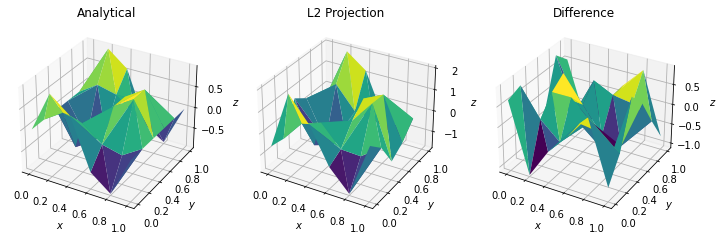

METHOD = midpoint_2d


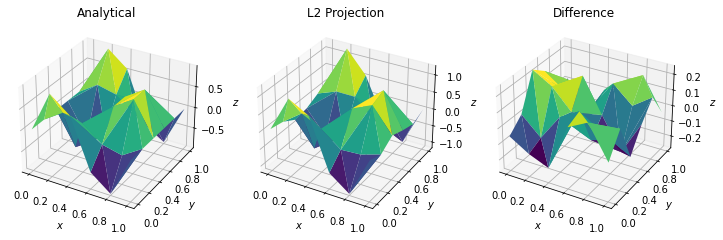

METHOD = trapezoid


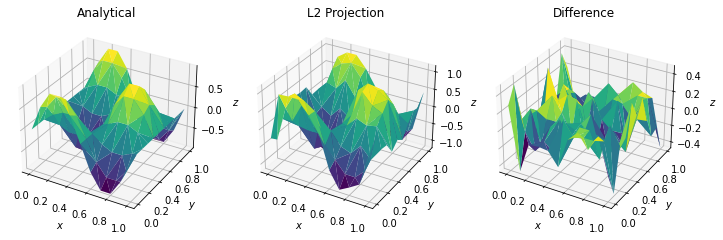

METHOD = midpoint_2d


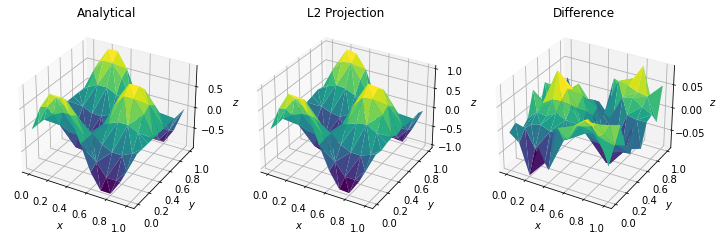

METHOD = trapezoid


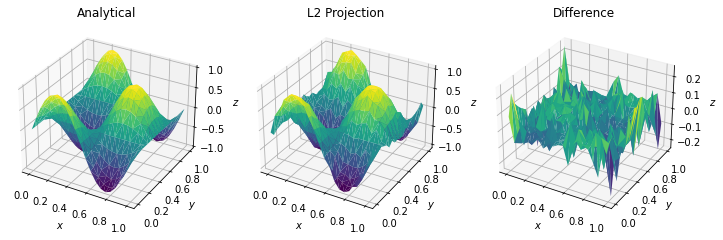

METHOD = midpoint_2d


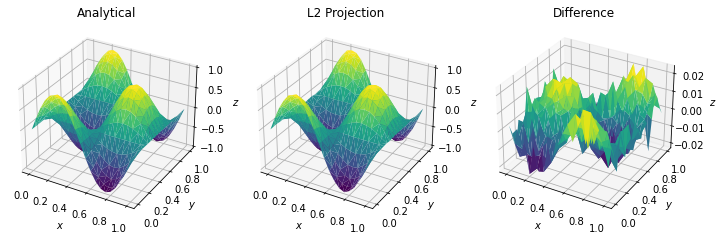

METHOD = trapezoid


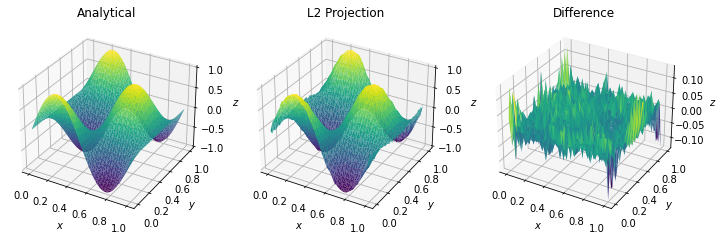

METHOD = midpoint_2d


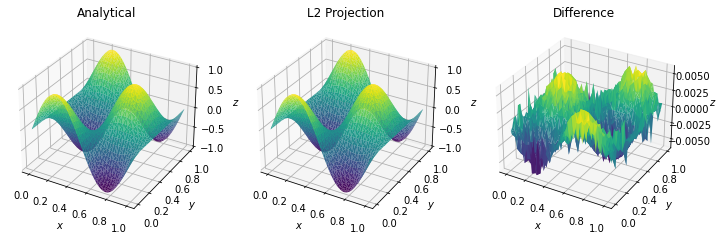

METHOD = trapezoid


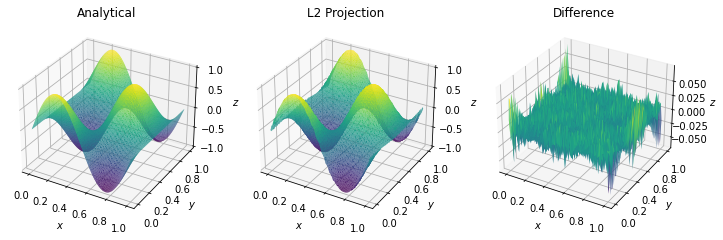

METHOD = midpoint_2d


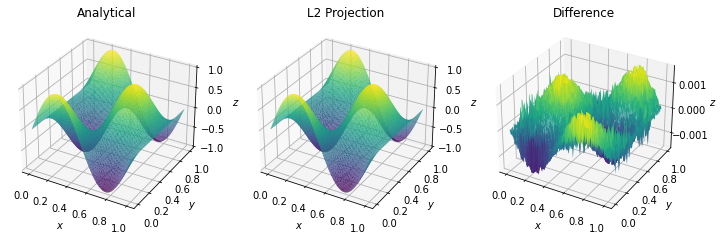

In [13]:
import matplotlib.pyplot as plt
from matplotlib import cm

f = lambda x,y: np.sin(2*np.pi * x)*np.cos(2*np.pi*y)

Ns = [5,10,20,40,80]
methods = ['trapezoid', 'midpoint_2d']
for N in Ns:
    for method in methods:
        print(f'METHOD = {method}')
        print('===========================')
        (P, T) = mt.rectangle_mesh((0,0), (1,1), N, N)
        M = assemble_mass_matrix(P,T)
        b = assemble_load_vector(P,T, f, method)
        M_csr = M.tocsr() 
        Phf = spsolve(M_csr, b)   
        Pf = f(P[:,0], P[:,1])
        plot_comparison_2D(P[:,0], P[:,1], Pf, Phf, T, 'Analytical', 'L2 Projection')

## Answer e)
From the figures above we can see that the error in the L2 projection is larger using the trapezoidal rule compared to the midpoint rule. This agrees with our expectations since we know that the midpoint rule is more accurate.

We can also see that the general pointwise behavior of the error differs betweeen the two methods. The trapezoidal method seem to produce errors that are more or less independent of the function's behavior, but seem to produce the highest error on the domain boundaries. The error of the midpoint method however seem to depend on the function's behavior. Specifically, the error seem to increase in places where the gradient of the function changes more rapidly. 

We have no good explanation for the observed bahaviour of the error for the trapeziodal method. For the midpoint rule however it makes sense that the error depends on the rate of change of the gradient of the function. The midpoint rule is exact for linear functions (this is also true for the Trapezoidal rule) and so when the gradient changes rapidely, approximating the function as a plane becomes less accurate resulting in a higher error.